# Training in mini-batches: Stochastic gradient descent

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/8.SGD-minibatch-mnist.ipynb)

We've been using generic gradient descent to optimize our model so far.  Because we've been estimating gradients using the entire `X` matrix, we call this batch gradient descent. Each update of the model parameters after considering all training instances is called an epoch. For batch gradient descent, there is one loss function computation per epoch.  If we process the training data in chunks rather than a single batch, we call it mini-batch gradient descent, or more commonly stochastic gradient descent (SGD). It is called stochastic because of the imprecision and, hence, randomness introduced by the computation of gradients on a subset of the training data. After we've computed a gradient and updated weights using all training instances, we call that an epoch, shuffle the batches, and do another epoch.

As before, we should run the network on a GPU.  The easiest way is just to click the icon there to run it at colab, and turn on the GPU runtime. (Go to "Change runtime type" under the runtime menu then select "GPU" under hardware accelerator; then select "Run all" under the runtime menu.) Or, you can still run it on your laptop/CPU; it'll just be slower.

## Why minibatch vs batch gradient descent?

<a href="https://twitter.com/ylecun/status/989610208497360896"><img src="https://explained.ai/rnn/images/lecunn-batch-size.png" width="250" align="right"></a>
Sometimes we have so much data that it will not fit on our GPU all at once; decent GPUs typically have around 12G of RAM.  For big problems, we need to break it up into batches.
 
Also, and possibly a more important goal, is to get better generalization; i.e., smaller validation loss. We want batch size to be as large as possible for efficiency on GPUs, but as small as possible to get the stochastic bouncing around down into lower and better minima.

* [Tradeoff batch size vs. number of iterations to train a neural network](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)
* [Why mini batch size is better than one single “batch” with all training data?](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data)
* [Revisiting Small Batch Training for Deep Neural Networks](https://arxiv.org/abs/1804.07612)

Let's redo the MNIST example using the GPU but with SGD.

In [1]:
import os
import sys
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Figure out whether we have a GPU; if not use the CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

Let's use a subset of the well-known MNIST handwritten digits data set. This is like the "hello world" of image recognition for deep learning. 

In [3]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [4]:
X.shape

(10000, 784)

In [5]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

In [6]:
X.shape

(10000, 784)

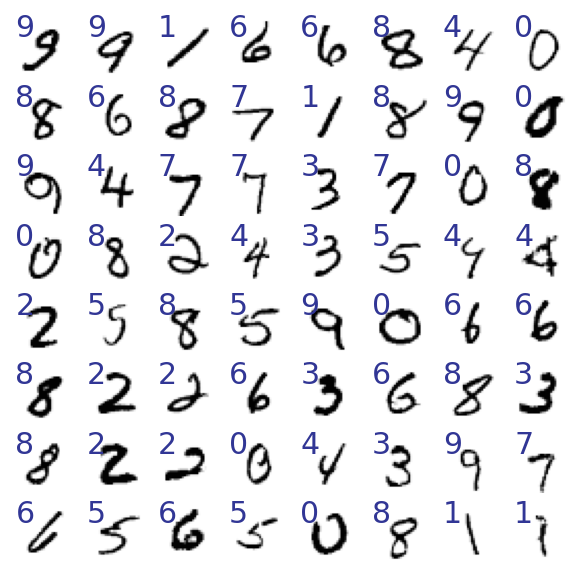

In [7]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

Now, let's create tensors from the X and y data; also indicate we want that data on the GPU:

In [8]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Training loop

In [9]:
def sgdtrain(model, X_train, y_train, X_test, y_test, 
             learning_rate = .0001, nepochs=2000, batch_size=32):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        # Must shuffle before each epoch
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            # extract a batch at index p
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            # Assume model yields softmax probabilities
            loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # This construct is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        # in this block of code
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        # Save all of the computations; loss.item() detaches
        # the hidden auto gradient computation graph.
        # Gets just the value. Otherwise, this procedure
        # runs out of memory on the GPU. 
        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

## Train with batch gradient descent

In [10]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

In [11]:
# On the CPU, this will take a very long time so
# use nepochs=500 instead if you don't have a GPU
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .03, nepochs=500,
                     batch_size=len(X_train)
                  )

Epoch    0 cross entropy loss  2.3022   test loss  2.1423
Epoch   50 cross entropy loss  1.6019   test loss  1.6176
Epoch  100 cross entropy loss  1.5843   test loss  1.6050
Epoch  150 cross entropy loss  1.5819   test loss  1.6028
Epoch  200 cross entropy loss  1.5811   test loss  1.6006
Epoch  250 cross entropy loss  1.5804   test loss  1.5990
Epoch  300 cross entropy loss  1.5790   test loss  1.5975
Epoch  350 cross entropy loss  1.5785   test loss  1.5970
Epoch  400 cross entropy loss  1.5779   test loss  1.5966
Epoch  450 cross entropy loss  1.5774   test loss  1.5951
Epoch  500 cross entropy loss  1.5773   test loss  1.5944
BEST test cross entropy loss 1.594 at epoch 500


In [12]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.880


In [13]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.864


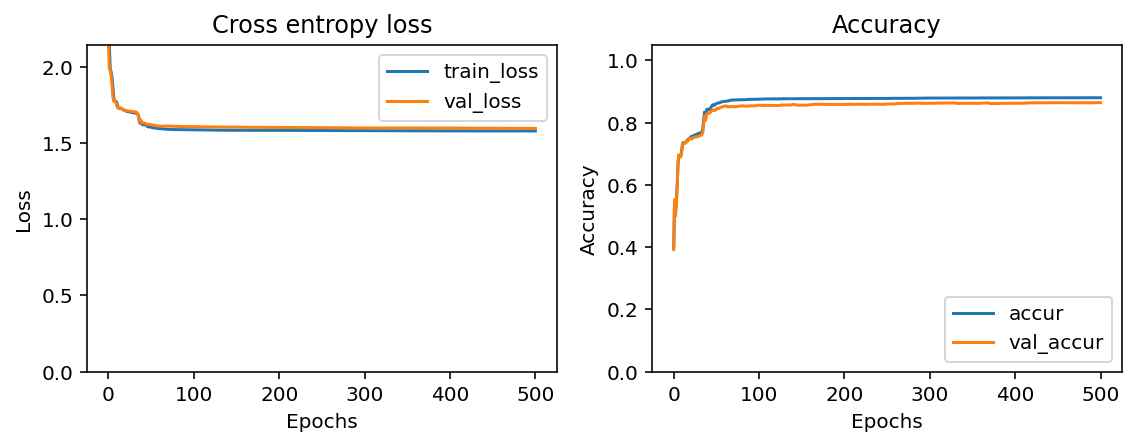

In [14]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

## Try mini-batch

Given the stochastic, imprecise nature of the gradient estimates, we need to decrease the learning rate so that we don't jump too far away along a path different from the true gradient.

In [15]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

In [16]:
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .001, nepochs=5000, # 5000 is good for GPU not CPU
                     batch_size=32
                  )

Epoch    0 cross entropy loss  1.6136   test loss  1.6009
Epoch   50 cross entropy loss  1.4714   test loss  1.4962
Epoch  100 cross entropy loss  1.4612   test loss  1.4948
Epoch  150 cross entropy loss  1.4924   test loss  1.4886


KeyboardInterrupt: 

In [ ]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

In [ ]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

## Try mini-batch with batch normalization

In [ ]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

In [ ]:
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .001, nepochs=5000,
                     batch_size=32
                  )

In [ ]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

In [ ]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

## Try a variety of mini batch sizes

In [ ]:
fig, axes = plt.subplots(1, 4,figsize=(12,2.5))
ncols = X.shape[1]
# for bs,ax in zip([1,16,32,64],axes):
for bs,ax in zip([8,16,32,64],axes):
    if bs>1:
        model = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),  # 10 output classes (0-9)
            nn.Softmax(dim=1)
        )
    else:
        model = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 10),  # 10 output classes (0-9)
            nn.Softmax(dim=1)
        )
    model = model.to(device)
    history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                         learning_rate = .001, nepochs=5000,
                         batch_size=bs
                        )
    ax.set_title(f"{100} neurons, bs={bs}")
    plot_loss(history, ax=ax, maxy=2.5)

plt.tight_layout()
plt.show()